In [1]:
from pathlib import Path

import math
import random

import numpy as np
import pandas as pd

from numba import njit

import matplotlib.pyplot as plt

In [2]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int):
        data = []
    
        for i in range(n):
            angle = random.uniform(0, 2*math.pi)
            dist = random.uniform(r1, r2)

            data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
        
        return np.array(data)

def gen_circle_smaple(c: tuple, r: float, n: int):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return np.array(data)

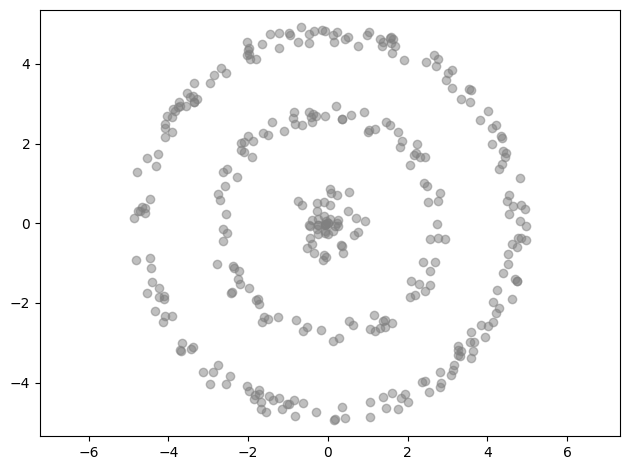

In [3]:
n_sample1 = 50
n_sample2 = 100
n_sample3 = 200

sample1 = gen_circle_smaple((0,0), 1, n_sample1)
sample2 = gen_ring_sample((0,0), 2.5, 3, n_sample2)
sample3 = gen_ring_sample((0,0), 4.5, 5, n_sample3)

data = np.vstack((sample1, sample2, sample3))

plt.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [4]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)

In [17]:
from math import sqrt

In [24]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def norm_squared(x: np.ndarray) -> float:
    return np.sum(np.square(x))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y

In [ ]:
@njit(fastmath=True)
def calc_forces(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    nn = p.shape[0]
    nx = x.shape[0]
    
    forces: np.ndarray = np.zeros(p.shape)
    
    for i in range(nn):
        dir_x = x - p[i]
        dx = np.sum(np.square(dir_x), axis=1).reshape((nx, 1))
        attr_forces = 1 / (dx + 1) * dir_x
        
        dir_pi = p[i] - p
        dp = np.sum(np.square(dir_pi), axis=1).reshape((nn, 1))
        separation_forces = 1 / (dp + 1) * dir_pi
        
        mean_attr_force = 1 / nx * np.sum(attr_forces, axis=0)
        mean_sep_force = 1 / nn * np.sum(separation_forces, axis=0)

        forces[i] = mean_attr_force + mean_sep_force
        
    return forces


def calc_bound_forces(x: np.ndarray, p: np.ndarray, d: np.ndarray, t: np.ndarray) -> np.ndarray:
    nn = p.shape[0]
    nx = x.shape[0]

    bound_forces: np.ndarray = np.zeros((nn, nn))

    for i in range(nx):
        u = ReLU(mcosim(p, x[i]))
        U = np.outer(u, u)

        bound_forces += 1/(1+t) * d * U

    return bound_forces


@njit(fastmath=True)
def activate(x: np.ndarray, p: np.ndarray, d: np.ndarray) -> np.ndarray:
    s = np.zeros(p.shape[0])

    dx = np.square(p - x)
    q = 1 / (np.sum(dx, axis=1) + 1)

    for j in range(p.shape[0]):
        s[j] += np.sum(q / (d[j] + 1))
    
    return s

In [134]:
class SelfOrganizingMap:
    def __init__(self, n: int, m: int) -> None:
        self.n: int = n
        self.m: int = m

        self.p: np.ndarray = np.random.uniform(-1, 1, (n, m))
        # self.w: np.ndarray = (1e-3 * np.ones((n, n))) * (1-np.eye(n))
        self.w: np.ndarray = np.zeros((n, n))
        self.d: np.ndarray = np.zeros((n, n))
    
    def calculate_distances_matrix(self):
        for i, pi in enumerate(self.p):
            for j, pj in enumerate(self.p):
                if i != j:
                    self.d[i][j] = 1 / np.sum(np.square(pi - pj))
    
    def activate(self, x: np.ndarray) -> np.ndarray:
        return activate(x, self.p, self.d)

    def learn_mapping(self, x_train: np.ndarray, lr: float, batch_size: int, max_epoch: int) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                forces = calc_forces(x_train[batch_idxs], self.p)

                self.p += lr * forces
    
    def learn_bounds(self, x_train: np.ndarray, lr: float, rr: float, batch_size: int, max_epoch: int) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size


        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            t = np.zeros((self.n, self.n))

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                bound_forces = calc_bound_forces(x_train[batch_idxs], self.p, self.d, t)

                self.w = rr * self.w + lr * bound_forces

                t += self.w

    def reset_bounds(self) -> None:
        self.w: np.ndarray = np.zeros((self.n, self.n))
        # self.w: np.ndarray = (1e-3 * np.ones((self.n, self.n))) * (1-np.eye(self.n))

In [135]:
m = 5
n = m * m

learning_rate = 1.0
batch_size = 16
max_epoch = 128

model = SelfOrganizingMap(n, 2)
model.learn_mapping(data, learning_rate, batch_size, max_epoch)

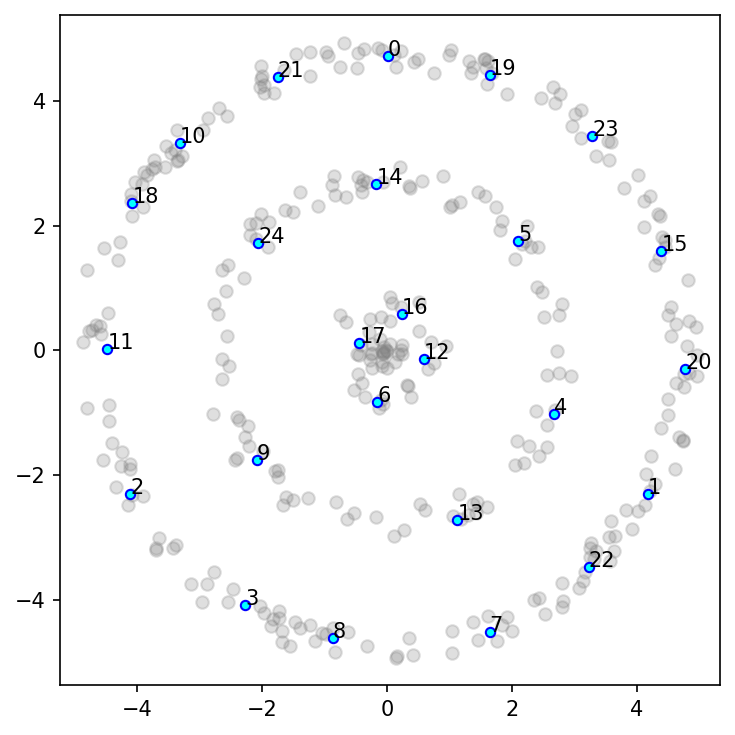

In [136]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot()

ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.25)
ax.scatter(model.p[:, 0], model.p[:, 1], s=20, c='cyan', edgecolors='blue')

for i in range(n):
    ax.annotate(str(i), (model.p[i][0], model.p[i][1]))

plt.axis('equal')
plt.tight_layout()
plt.show()

In [137]:
model.calculate_distances_matrix()

In [142]:
learning_rate = 1.0
relaxation_rate = 0.5

model.reset_bounds()
model.learn_bounds(data, learning_rate, relaxation_rate, batch_size, 64)

0.0 0.3316216143472083


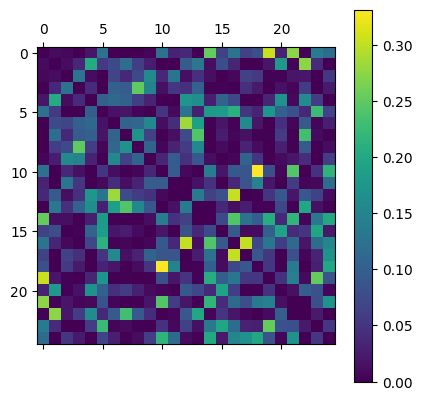

In [143]:
print(np.min(model.w), np.max(model.w))
img = plt.matshow(model.w, cmap='viridis')
plt.colorbar(img)
plt.show()

In [140]:
from matplotlib.cm import binary, viridis

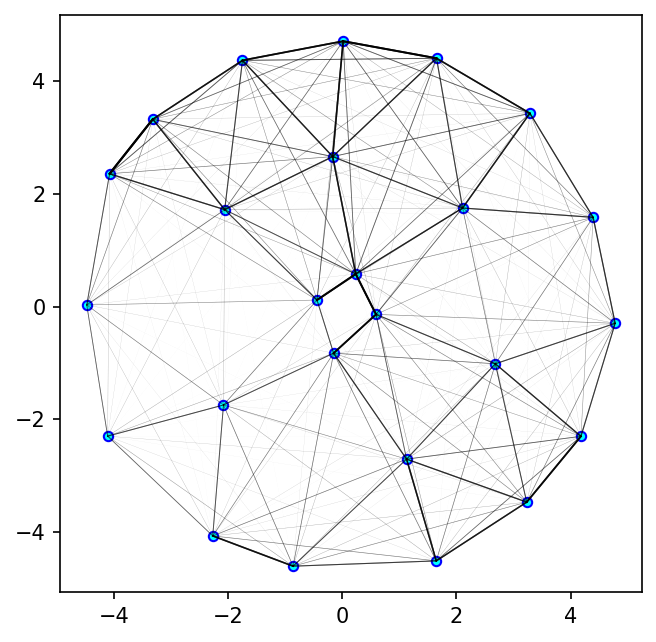

In [144]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot()

# ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.25)

w = (model.w - np.min(model.w)) / (np.max(model.w) - np.min(model.w))

for i, pi in enumerate(model.p):
    for j, pj in enumerate(model.p):
        x = [pi[0], pj[0]]
        y = [pi[1], pj[1]]
        c = binary(255 * w[i][j])
        ax.plot(x, y, c=c, alpha=w[i][j], lw=w[i][j])

ax.scatter(model.p[:, 0], model.p[:, 1], s=20, c='cyan', edgecolors='blue')

plt.show()